In [1]:
"""
use time to cut sequences
command 
python main_time.py --data_folder ../Data/xing/ --train_data train_item.pickle --valid_data test_item.pickle --test_data test_item.pickle --data_name xing --embedding_dim 300 --hidden_size 300 --lr 0.005
"""
import argparse
import torch
# import lib
import numpy as np
import os
import datetime
from loss import *
from network import *
from optimizer import *
from trainer import *
from torch.utils import data
import pickle
import sys
from dataset_time import *
# from data_time import *
from logger import *
import collections

import sys
sys.path.insert(0, '../PyTorch_GBW_LM')
sys.path.insert(0, '../PyTorch_GBW_LM/log_uniform')

from sampledSoftmax import *

In [2]:
import matplotlib.pyplot as plt

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--hidden_size', default=50, type=int)
parser.add_argument('--num_layers', default=1, type=int)
parser.add_argument('--batch_size', default=100, type=int)
parser.add_argument('--dropout_input', default=0, type=float)
parser.add_argument('--dropout_hidden', default=.2, type=float)

# parse the optimizer arguments
parser.add_argument('--optimizer_type', default='Adagrad', type=str)
parser.add_argument('--final_act', default='tanh', type=str)
parser.add_argument('--lr', default=.05, type=float)
parser.add_argument('--weight_decay', default=0.0, type=float)
parser.add_argument('--momentum', default=0.1, type=float)
parser.add_argument('--eps', default=1e-6, type=float)

parser.add_argument("-seed", type=int, default=7,
                     help="Seed for random initialization")
parser.add_argument("-sigma", type=float, default=None,
                     help="init weight -1: range [-sigma, sigma], -2: range [0, sigma]")
parser.add_argument("--embedding_dim", type=int, default=-1,
                     help="using embedding")
# parse the loss type
parser.add_argument('--loss_type', default='TOP1', type=str)
# parser.add_argument('--loss_type', default='BPR', type=str)
parser.add_argument('--topk', default=5, type=int)
# etc
parser.add_argument('--bptt', default=1, type=int)
parser.add_argument('--test_observed', default=5, type=int)
parser.add_argument('--window_size', default=30, type=int)
parser.add_argument('--warm_start', default=5, type=int)

parser.add_argument('--n_epochs', default=20, type=int)
parser.add_argument('--time_sort', default=False, type=bool)
parser.add_argument('--save_dir', default='models', type=str)
parser.add_argument('--data_folder', default='../Data/movielen/1m/', type=str)
parser.add_argument('--data_action', default='item.pickle', type=str)
parser.add_argument('--data_cate', default='cate.pickle', type=str)
parser.add_argument('--data_time', default='time.pickle', type=str)
parser.add_argument("--is_eval", action='store_true')
parser.add_argument('--load_model', default=None,  type=str)
parser.add_argument('--checkpoint_dir', type=str, default='checkpoint')
parser.add_argument('--data_name', default=None, type=str)
parser.add_argument('--shared_embedding', default=None, type=int)
parser.add_argument('--patience', default=1000)
parser.add_argument('--negative_num', default=1000, type=int)
parser.add_argument('--valid_start_time', default=0, type=int)
parser.add_argument('--test_start_time', default=0, type=int)
parser.add_argument('--model_name', default="samplePaddingSessionRNN", type=str)

# Get the arguments
args = parser.parse_args([])
args.cuda = torch.cuda.is_available()

In [4]:
# CUDA_VISIBLE_DEVICES=0 python eval_main_time.py --data_folder ../Data/tmall/100k_unknown_cate/ 
# --data_action item_time.pickle --data_cate cate_time.pickle --data_time time_time.pickle 
# --data_name taobao --embedding_dim 300 --hidden_size 300 --lr 0.001 --window_size 20 
# --test_observed 5 --n_epochs 100 --shared_embedding 1 --batch_size 300 
# --optimizer_type Adam --loss_type 'XE' --valid_start_time 1512172800 --test_start_time 1512259200 
# --negative_num 10000 --topk 20 --checkpoint_dir "../log/samplePaddingSessionRNN/checkpoint/01022149"


In [5]:
args.data_folder = "../../../Data/tmall/100k_unknown_cate/"
args.data_action = "item_time.pickle"
args.data_cate = "cate_time.pickle"
args.data_time = "time_time.pickle"
args.data_name = "taobao"
args.embedding_dim = 256
args.hidden_size = 256
args.lr = 0.001
args.window_size = 20
args.test_observed = 5
args.n_epochs = 100
args.shared_embedding = 1
args.batch_size = 8
args.optimizer_type = "Adam"
args.loss_type = "XE"
args.valid_start_time = 1512172800
args.test_start_time = 1512259200
args.negative_num = 10000
args.topk = 20
args.checkpoint_dir = "../../log/samplePaddingSessionRNN/checkpoint/01031151"

In [6]:
np.random.seed(args.seed)
torch.manual_seed(7)
random.seed(args.seed)

if args.cuda:
    print("gpu")
    torch.cuda.manual_seed(args.seed)
else:
    print("cpu")

gpu


In [7]:
# 1512172800: 12/02/2017 @ 12:00am (UTC)
### 1512187200: 12/02/2017 @ 4:00am (UTC)
## 1512201600: 12/02/2017 @ 8:00am (UTC)
### 1512216000: 12/02/2017 @ 12:00pm (UTC)
### 1512230400: 12/02/2017 @ 4:00pm (UTC)
### 1512244800: 12/02/2017 @ 8:00pm (UTC)
# 1512259200: 12/03/2017 @ 12:00am (UTC)

In [8]:
def make_checkpoint_dir(log):
    print("PARAMETER" + "-"*10)
    now = datetime.datetime.now()
    S = '{:02d}{:02d}{:02d}{:02d}'.format(now.month, now.day, now.hour, now.minute)
    checkpoint_dir = "../log/"+args.model_name+"/"+args.checkpoint_dir
    args.checkpoint_dir = checkpoint_dir
    save_dir = os.path.join(args.checkpoint_dir, S)

    if not os.path.exists("../log"):
        os.mkdir("../log")
    
    if not os.path.exists("../log/"+args.model_name):
        os.mkdir("../log/"+args.model_name)

    if not os.path.exists(args.checkpoint_dir):
        os.mkdir(args.checkpoint_dir)

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    args.checkpoint_dir = save_dir
    
    with open(os.path.join(args.checkpoint_dir, 'parameter.txt'), 'w') as f:
        for attr, value in sorted(args.__dict__.items()):
            msg = "{}={}".format(attr.upper(), value)
            log.addOutput2IO(msg)
            f.write("{}={}\n".format(attr.upper(), value))

    msg = "---------" + "-"*10
    log.addOutput2IO(msg)

def load_args(model_path):
    model_file = os.path.join(model_path, "model_best.pt")
    print("args file load", model_file)
    check_point = torch.load(model_file)
    args = check_point['args']

def load_model(network, model_path):
    print("reload model")
    model_file = os.path.join(model_path, "model_best.pt")
    print("model file", model_file)
    check_point = torch.load(model_file)

    network.load_state_dict(check_point['model'])

def count_parameters(model):
    parameter_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("parameter_num", parameter_num) 


In [9]:
model_path = args.checkpoint_dir
load_args(model_path)

BPTT = args.bptt

device = torch.device('cuda' if args.cuda else 'cpu')
print("device", device)

if args.embedding_dim == -1:
    raise AssertionError()

data_name = args.data_name

print("*"*10+"train load"+"*"*10)

observed_threshold = args.test_observed

data_action = args.data_folder+args.data_action
data_cate = args.data_folder+args.data_cate
data_time = args.data_folder+args.data_time

valid_start_time = args.valid_start_time
test_start_time = args.test_start_time

st = datetime.datetime.now()
data_obj = MYDATA(data_action, data_cate, data_time, valid_start_time, test_start_time, observed_threshold, args.window_size)
et = datetime.datetime.now()
print("load data duration ", et-st)

train_data = data_obj.train_dataset
valid_data = data_obj.test_dataset
test_data = data_obj.test_dataset

print("+"*10+"valid load"+"+"*10)

input_size = data_obj.items()
output_size = input_size

negative_num = args.negative_num

train_data_loader = MYDATALOADER(train_data, args.batch_size)
valid_data_loader = MYDATALOADER(valid_data, args.batch_size)
test_data_loader = MYDATALOADER(valid_data, args.batch_size)

ss = SampledSoftmax(output_size, negative_num, args.embedding_dim, None)

network = NETWORK(input_size, ss, args, device)
load_model(network, model_path)

### eval
loss_function = LossFunction(device, loss_type=args.loss_type)

topk = args.topk
eval = Evaluation(None, network, loss_function, device, topk, args.warm_start)

args file load ../../log/samplePaddingSessionRNN/checkpoint/01031151/model_best.pt
device cuda
**********train load**********
action seq num 51275
time seq num 51275
loading item map
loading item map
observed_threshold 5 20
loading data
valid_start_time 1512172800
test start time 1512259200
seq num for training 2738883
seq num of actions for training 2738883
seq num for testing 430797
seq num of actions for testing 430797
load data duration  0:00:09.013674
++++++++++valid load++++++++++
item num 68008
seq num 2738883
batch size 8
batch_num 342360
seq num 430797
batch size 8
batch_num 53849
seq num 430797
batch size 8
batch_num 53849


/u/sr3hd/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


reload model
model file ../../log/samplePaddingSessionRNN/checkpoint/01031151/model_best.pt


In [10]:
from sklearn.cluster import KMeans
def set_bucket4item(data):
    item_freq_dict = dict(Counter(data.m_y_action))
    freq_list = list(item_freq_dict.values())
    num_clusters = 6
    itemid_bucketid_dict = {}
    bucketid_itemidlist_dict = {}
    popularities = np.array(freq_list)
    
    # For each popularity, assign corresponding bucket
    if len(popularities) > 0:
        clusters = KMeans(num_clusters)
        #cluster label for each item popularity
        labels = clusters.fit_predict(popularities.reshape(-1, 1))
        centroids = clusters.cluster_centers_
        sorted_centroids = sorted(centroids)
        sorted_clusters = []
        
        # Cluster labels originally not in order, sort them so index of sorted list
        # is the new correct bucket
        for num in range(num_clusters):
            i = np.where(centroids == sorted_centroids[num])
            sorted_clusters.append(i[0][0])
        
        # Assign items their bucket and which items belong in each bucket
        for x, label in enumerate(labels):
                bucket = sorted_clusters.index(label)
                itemid = list(item_freq_dict.keys())[x]
                
                itemid_bucketid_dict[itemid] = bucket
                if bucket not in bucketid_itemidlist_dict:
                    bucketid_itemidlist_dict[bucket] = []
                bucketid_itemidlist_dict[bucket].append(itemid)

    print("buckets =", len(bucketid_itemidlist_dict), bucketid_itemidlist_dict.keys())
#     for bucketid in bucketid_itemidlist_dict:
    for bucketid in range(0, len(bucketid_itemidlist_dict)):
        itemid_list_bucket = bucketid_itemidlist_dict[bucketid]
        freq_bucket = 0
        for itemid in itemid_list_bucket:
            freq_bucket += item_freq_dict[itemid]
        print("bucket %d, freq: %d, item num: %d"%(bucketid, freq_bucket, len(itemid_list_bucket)))

    return item_freq_dict, itemid_bucketid_dict, bucketid_itemidlist_dict

In [11]:
train_item_freq_dict, train_itemid_bucketid_dict, train_bucketid_itemidlist_dict = set_bucket4item(train_data)

buckets = 6 dict_keys([0, 1, 4, 2, 3, 5])
bucket 0, freq: 1093966, item num: 48371
bucket 1, freq: 778762, item num: 14231
bucket 2, freq: 475955, item num: 4096
bucket 3, freq: 253044, item num: 1061
bucket 4, freq: 108294, item num: 222
bucket 5, freq: 28862, item num: 25


In [12]:
# Time intervals are seperate so each has their own distinct popularities, not global or dynamic
def set_buckets4time_as_preds(data, time_pop_item_dict=None, time_pop_fp_dict=None):
    if time_pop_item_dict == None : time_pop_item_dict = {}
    if time_pop_fp_dict == None : time_pop_fp_dict = {}
    num_clusters = 6
    item_freq_dict_time = {}
    num_preds = 0
    for y in zip(data.m_y_action):
        timeid = len(time_pop_item_dict)
        num_preds+=1
#         for i, t in enumerate(time_intervals):
#              if time <= t:
#                  timeid = t
        # Time interval is every 500000 predictions, want to limit time intervals to avoid longer
        # computation time on temporal discounting
        timeid += num_preds // 500000
        
        # Get popularity of items at different time periods, each independent of the other
        if timeid not in item_freq_dict_time:
            item_freq_dict_time[timeid] = {}
        if y not in item_freq_dict_time[timeid]:
            item_freq_dict_time[timeid][y] = 0
        item_freq_dict_time[timeid][y] += 1
        
    for time in item_freq_dict_time:
        popularities = np.array(list(item_freq_dict_time[time].values()))
        if len(popularities) > 0:
            clusters = KMeans(num_clusters)
            labels = clusters.fit_predict(popularities.reshape(-1, 1))
            centroids = clusters.cluster_centers_
            sorted_centroids = sorted(centroids)
            sorted_clusters = [] #Cluster number at position of magnitude, least to greatest
            
            for num in range(num_clusters):
                i = np.where(centroids == sorted_centroids[num]) # Gives original cluster number
                sorted_clusters.append(i[0][0])
            
            if time not in time_pop_item_dict:
                time_pop_item_dict[time] = {}
            if time not in time_pop_fp_dict:
                time_pop_fp_dict[time] = {}
                
            for x, label in enumerate(labels):
                label = sorted_clusters.index(label) # Get label associated with order of cluster
                itemid = list(item_freq_dict_time[time].keys())[x][0]
                
                if label not in time_pop_item_dict[time]:
                    time_pop_item_dict[time][label] = []
                time_pop_item_dict[time][label].append(itemid)
                
                # Want to store false positive and true negative numbers to calculate false postive rate
                if label not in time_pop_fp_dict[time]:
                    time_pop_fp_dict[time][label] = {}
                if "fp" not in time_pop_fp_dict[time][label]:
                    time_pop_fp_dict[time][label]["fp"] = 0.
                if "tn" not in time_pop_fp_dict[time][label]:
                    time_pop_fp_dict[time][label]["tn"] = 0.
                if "rate" not in time_pop_fp_dict[time][label]:
                    time_pop_fp_dict[time][label]["rate"] = 0.
        
    return time_pop_item_dict, time_pop_fp_dict

In [13]:
time_pop_item_dict, time_pop_fp_dict = set_buckets4time_as_preds(train_data)
train_time = len(time_pop_item_dict)
print(train_time)
time_pop_item_dict, time_pop_fp_dict = set_buckets4time_as_preds(test_data, time_pop_item_dict, time_pop_fp_dict)
len(time_pop_item_dict)

6


7

In [14]:
# Get bucket of item at a certain time
def get_item_bucket(time, item):
    for bucket in time_pop_item_dict[time]:
        if item in time_pop_item_dict[time][bucket]:
            return bucket
    return None

# Training

In [15]:
def bias_eval(eval_data, itemid_bucketid_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = 20
    
    item_recall_dict = {}
    item_mrr_dict = {}

    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, \
            pad_x_short_actionNum_batch, y_action_batch, y_action_idx_batch, user_batch in dataloader:
            
#             eval_flag = random.randint(1,101)
#             if eval_flag != 10:
#                 continue

            batch_item_recall_dict = {}
            batch_item_mrr_dict = {}

            x_short_action_batch = x_short_action_batch.to(device)
            mask_short_action_batch = mask_short_action_batch.to(device)
            y_action_batch = y_action_batch.to(device)
            user_batch = user_batch.to(device)

            # warm_start_mask = (y_action_idx_batch>=self.warm_start)

            output_batch = network(x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch)

            sampled_logit_batch, sampled_target_batch = network.m_ss(output_batch, y_action_batch, \
                                                        None, None, None, None, None, None, "full")
 
            loss_batch = loss_function(sampled_logit_batch, sampled_target_batch)
            losses.append(loss_batch.item())

            _, preds = torch.topk(sampled_logit_batch, topk, -1)
            preds = preds.cpu()
            targets = sampled_target_batch.cpu()

            expand_targets = targets.view(-1, 1).expand_as(preds)
            hits = (preds == expand_targets)
            
            # Evaluate Recall and MRR
            for i, hit in enumerate(hits):
                target_i = targets[i]
                itemid_i = target_i.item()
                
                rank = hit.nonzero()
                
                if itemid_i not in batch_item_recall_dict:
                    batch_item_recall_dict[itemid_i] = []
                    batch_item_mrr_dict[itemid_i] = []
                
                if len(rank) == 1:
                    batch_item_recall_dict[itemid_i].append(1.0)
                    
                    rank = rank[0]+1.0
                    rank = torch.reciprocal(rank.float())
                    batch_item_mrr_dict[itemid_i].append(rank.item())
                else:
                    batch_item_recall_dict[itemid_i].append(0.0)
                    batch_item_mrr_dict[itemid_i].append(0.0)
                    
                
            for item in batch_item_recall_dict:
                batch_mean_recall = np.mean(batch_item_recall_dict[item])
                batch_mean_mrr = np.mean(batch_item_mrr_dict[item])
                
                if item not in item_recall_dict:
                    item_recall_dict[item] = []
                    item_mrr_dict[item] = []
                item_recall_dict[item].append(batch_mean_recall)
                item_mrr_dict[item].append(batch_mean_mrr)
                
            total_test_num.append(y_action_batch.view(-1).size(0))
    return item_recall_dict, item_mrr_dict, user_itemrank_dict, user_itempop_dict
    

In [17]:
item_recall_dict, item_mrr_dict, train_user_itemrank_dict, train_user_itempop_dict = bias_eval(train_data_loader, train_itemid_bucketid_dict)

shuffling


<ipython-input-15-1b269b6265c8>:66: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  rank = hit.nonzero()


In [18]:
bucket_recall_dict = {}
bucket_mrr_dict = {}
for item in item_recall_dict:
    bucketid = train_itemid_bucketid_dict[item]
    item_recall = np.mean(item_recall_dict[item])
    
#     item_recall = item_recall[0]*1.0/item_recall[1]
    if bucketid not in bucket_recall_dict:
        bucket_recall_dict[bucketid] = []
        bucket_mrr_dict[bucketid] = []
    bucket_recall_dict[bucketid].append(item_recall)
    
    item_mrr = np.mean(item_mrr_dict[item])
#     item_mrr = item_mrr[0]*1.0/item_mrr[1]
    bucket_mrr_dict[bucketid].append(item_mrr)

for bucket in bucket_recall_dict:
    recall_list = bucket_recall_dict[bucket]
    mean_recall = np.mean(recall_list)
    bucket_recall_dict[bucket] = mean_recall

for bucket in bucket_mrr_dict:
    mrr_list = bucket_mrr_dict[bucket]
    mean_mrr = np.mean(mrr_list)
    bucket_mrr_dict[bucket] = mean_mrr  

In [19]:
sorted_bucket_recall_dict = {k:v for k, v in sorted(bucket_recall_dict.items(), key=lambda x: x[0], reverse=True)}
sorted_bucket_mrr_dict = {k:v for k, v in sorted(bucket_mrr_dict.items(), key=lambda x: x[0], reverse=True)}

In [20]:
print("recall")
for i in range(0, 6):
    print("%d:%.4f"%(i, bucket_recall_dict[i]), end=", ")
print()
print(np.mean(list(bucket_recall_dict.values())))
print("mrr")
for i in range(0,6):
    print("%d:%.4f"%(i, bucket_mrr_dict[i]), end=", ")
print()
print(np.mean(list(bucket_mrr_dict.values())))

recall
0:0.3161, 1:0.3366, 2:0.3456, 3:0.3607, 4:0.3851, 5:0.4626, 
0.3677961196765793
mrr
0:0.1444, 1:0.1301, 2:0.1167, 3:0.1171, 4:0.1274, 5:0.2125, 
0.14136309468400562


# Testing

In [21]:
def bias_eval(itemid_bucketid_dict):

    losses = []
    recalls = []
    mrrs = []
    weights = []
    
    item_recall_dict = {}
    item_mrr_dict = {}
    
    num_batch = 0
    num_preds = 0
    
    # loading from prevoiusly made file
    # file creation detailed in eval_taobao_load
    model_df = pd.read_csv("test_results@20.csv.gz", compression="gzip")
    
    batch_item_recall_dict = {}
    batch_item_mrr_dict = {}
    max_time = train_time
    
    # Split into 10000 batches
    for batch in np.array_split(model_df, 10000):
        preds = torch.tensor(batch.iloc[:,1:-1].values.tolist())
        targets = torch.tensor(batch[:]["target"].values.tolist())
        
        expand_targets = targets.view(-1, 1).expand_as(preds)
        hits = (preds == expand_targets)
        
        # Calculate false positive and true negative numbers
        # True negatives are calculated by subtracting false negatives, true positives, and false
        # positives from total preds
        for seq, seq_preds in enumerate(preds):
            target = targets[seq].item()
            for time in time_pop_fp_dict:
                pop_bucket_target = get_item_bucket(time, target)
                
                predicted = False #Check whether target in list of predictions
                
                for pred in seq_preds:
                    num_preds += 1
                    pred = pred.item()
                    pop_bucket_pred = get_item_bucket(time, pred)
                    
                    # False positive if in topk but not the target
                    if pred != target and pop_bucket_pred != None:
                        time_pop_fp_dict[time][pop_bucket_pred]["fp"] += 1.0
                        
                    elif pred == target:
                        predicted = True
                    
                    # Not true negative if not correctly predict target in topk, true positive
                    if pop_bucket_pred != None:
                        time_pop_fp_dict[time][pop_bucket_pred]["tn"] -= 1.0

                #If target never predicted then must have 1 false negative
                if not predicted and pop_bucket_target != None:
                    time_pop_fp_dict[time][pop_bucket_target]["tn"] -= 1.0
                    

        for i, hit in enumerate(hits):
            target_i = targets[i]
            itemid_i = target_i.item()

            rank = hit.nonzero()

            if itemid_i not in batch_item_recall_dict:
                batch_item_recall_dict[itemid_i] = []
                batch_item_mrr_dict[itemid_i] = []

            if len(rank) == 1:
                batch_item_recall_dict[itemid_i].append(1.0)

                rank = rank[0]+1.0
                rank = torch.reciprocal(rank.float())
                batch_item_mrr_dict[itemid_i].append(rank.item())
            else:
                batch_item_recall_dict[itemid_i].append(0.0)
                batch_item_mrr_dict[itemid_i].append(0.0)


        for item in batch_item_recall_dict:
            batch_mean_recall = np.mean(batch_item_recall_dict[item])
            batch_mean_mrr = np.mean(batch_item_mrr_dict[item])

            if item not in item_recall_dict:
                item_recall_dict[item] = []
                item_mrr_dict[item] = []
            item_recall_dict[item].append(batch_mean_recall)
            item_mrr_dict[item].append(batch_mean_mrr)
    
    return item_recall_dict, item_mrr_dict, num_preds
    

In [22]:
test_item_recall_dict, test_item_mrr_dict, num_preds = bias_eval(train_itemid_bucketid_dict)

In [23]:
bucket_recall_dict = {}
bucket_mrr_dict = {}
for item in test_item_recall_dict:
    bucketid = train_itemid_bucketid_dict[item]
    item_recall = np.mean(test_item_recall_dict[item])
    
#     item_recall = item_recall[0]*1.0/item_recall[1]
    if bucketid not in bucket_recall_dict:
        bucket_recall_dict[bucketid] = []
        bucket_mrr_dict[bucketid] = []
    bucket_recall_dict[bucketid].append(item_recall)
    
    item_mrr = np.mean(test_item_mrr_dict[item])
#     item_mrr = item_mrr[0]*1.0/item_mrr[1]
    bucket_mrr_dict[bucketid].append(item_mrr)

for bucket in bucket_recall_dict:
    recall_list = bucket_recall_dict[bucket]
    mean_recall = np.mean(recall_list)
    bucket_recall_dict[bucket] = mean_recall

for bucket in bucket_mrr_dict:
    mrr_list = bucket_mrr_dict[bucket]
    mean_mrr = np.mean(mrr_list)
    bucket_mrr_dict[bucket] = mean_mrr  

In [24]:
print("recall")
for i in range(0, 6):
    print("%d:%.4f"%(i, bucket_recall_dict[i]), end=", ")
print()
print(np.mean(list(bucket_recall_dict.values())))
print("mrr")
for i in range(0,6):
    print("%d:%.4f"%(i, bucket_mrr_dict[i]), end=", ")
print()
print(np.mean(list(bucket_mrr_dict.values())))

recall
0:0.1379, 1:0.1743, 2:0.2036, 3:0.2475, 4:0.2792, 5:0.2834, 
0.22097856475605168
mrr
0:0.0663, 1:0.0721, 2:0.0721, 3:0.0866, 4:0.0999, 5:0.0993, 
0.08269678698443751


In [55]:
for time in time_pop_fp_dict:
    for bucket in time_pop_fp_dict[time]:
        # Add number of predction to pre-subtracted value of true negative that accounted for 
        # true positives and false negatives
        time_pop_fp_dict[time][bucket]["tn"] += num_preds
        # Now further subtract false positive counts
        time_pop_fp_dict[time][bucket]["tn"] -= time_pop_fp_dict[time][bucket]["fp"]
        fp = time_pop_fp_dict[time][bucket]["fp"]
        tn = time_pop_fp_dict[time][bucket]["tn"] 
        time_pop_fp_dict[time][bucket]["rate"] = fp / (fp + tn)
time_pop_fp_dict

{0: {0: {'fp': 4677241.0, 'tn': 111142904.0, 'rate': 0.040383656919096414},
  1: {'fp': 2120853.0, 'tn': 116249021.0, 'rate': 0.017917168687701737},
  4: {'fp': 305101.0, 'tn': 119987363.0, 'rate': 0.002536326797662071},
  3: {'fp': 432157.0, 'tn': 119703544.0, 'rate': 0.0035972404239768825},
  2: {'fp': 728239.0, 'tn': 119075690.0, 'rate': 0.006078590293979423},
  5: {'fp': 90836.0, 'tn': 120435279.0, 'rate': 0.0007536623909266468}},
 1: {1: {'fp': 1695853.0, 'tn': 117104258.0, 'rate': 0.014274843564750542},
  0: {'fp': 5166607.0, 'tn': 110139524.0, 'rate': 0.04480773880098362},
  2: {'fp': 623282.0, 'tn': 119295076.0, 'rate': 0.00519755282172893},
  3: {'fp': 414695.0, 'tn': 119744698.0, 'rate': 0.0034512075140060005},
  5: {'fp': 103218.0, 'tn': 120409864.0, 'rate': 0.0008564879288374685},
  4: {'fp': 259155.0, 'tn': 120084280.0, 'rate': 0.0021534618818218046}},
 2: {0: {'fp': 5155532.0, 'tn': 110161648.0, 'rate': 0.044707406129771816},
  1: {'fp': 1620863.0, 'tn': 117259782.0, 'rat

In [56]:
def get_weights(num_times, func="exp", rate=1):
    weights = []
    if func == "exp":
        for t in range(1, num_times+1):
            w = math.pow(math.e, 1/(1.5*t)) - 1
            weights.append(w)
    elif func == "log":
        for t in range(1, num_times+1):
            w = rate * math.log(t) + .99
            weights.append(w)
    return weights

In [57]:
temporal_multiplier = 0
num_times = len(time_pop_fp_dict)
time_weights = get_weights(num_times, "log", -1/5)
for time in time_pop_fp_dict:
    var_t = np.var([time_pop_fp_dict[time][bucket]["rate"] for bucket in time_pop_fp_dict[time]])
    temporal_multiplier += var_t * time_weights[num_times-(time+1)]
temporal_multiplier

0.0010576558981427034

In [58]:
temporal_multiplier = 0
time_weights = get_weights(num_times)
for time in time_pop_fp_dict:
    var_t = np.var([time_pop_fp_dict[time][bucket]["rate"] for bucket in time_pop_fp_dict[time]])
    temporal_multiplier += var_t * time_weights[num_times-(time+1)]
temporal_multiplier

0.0004031306360389908

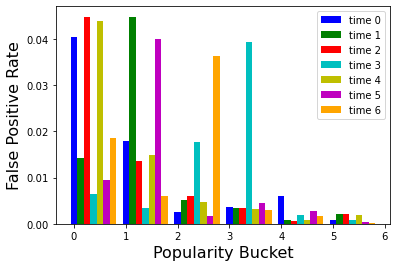

In [59]:
w = 0.125
plt.bar([0,1,2,3,4,5], [time_pop_fp_dict[0][bucket]["rate"] for bucket in time_pop_fp_dict[0]], width=w, color='b', label="time 0", align='center')
plt.bar(np.array([0,1,2,3,4,5])+w, [time_pop_fp_dict[1][bucket]["rate"] for bucket in time_pop_fp_dict[1]], width=w, color='g', label="time 1", align='center')
plt.bar(np.array([0,1,2,3,4,5])+(w*2), [time_pop_fp_dict[2][bucket]["rate"] for bucket in time_pop_fp_dict[2]], width=w, color='r', label="time 2", align='center')
plt.bar(np.array([0,1,2,3,4,5])+(w*3), [time_pop_fp_dict[3][bucket]["rate"] for bucket in time_pop_fp_dict[3]], width=w, color='c', label="time 3", align='center')
plt.bar(np.array([0,1,2,3,4,5])+(w*4), [time_pop_fp_dict[4][bucket]["rate"] for bucket in time_pop_fp_dict[4]], width=w, color='y', label="time 4", align='center')
plt.bar(np.array([0,1,2,3,4,5])+(w*5), [time_pop_fp_dict[5][bucket]["rate"] for bucket in time_pop_fp_dict[5]], width=w, color='m', label="time 5", align='center')
plt.bar(np.array([0,1,2,3,4,5])+(w*6), [time_pop_fp_dict[6][bucket]["rate"] for bucket in time_pop_fp_dict[6]], width=w, color='orange', label="time 6", align='center')
plt.xlabel('Popularity Bucket', fontsize=16)
plt.ylabel('False Positive Rate', fontsize=16)
plt.legend()
plt.show()

### re-rank the results by debiasing method

#### get the score of the prediction

In [32]:
comp_time_pop_fp_dict = time_pop_fp_dict
for time in time_pop_fp_dict:
    for bucket in time_pop_fp_dict[time]:
        for stat in time_pop_fp_dict[time][bucket]:
            comp_time_pop_fp_dict[time][bucket][stat] = 0

In [33]:
def compensated_bias_eval(itemid_bucketid_dict, alpha, beta):
    losses = []
    recalls = []
    mrrs = []
    weights = []
    
    topk = 5
    
    item_recall_dict = {}
    item_mrr_dict = {}
    
    num_batch = 0
    num_preds = 0
    
    model_df = pd.read_csv("compensated_test@20.csv.gz", compression="gzip")
    
    batch_item_recall_dict = {}
    batch_item_mrr_dict = {}
    max_time = train_time
    
    for batch in np.array_split(model_df, 10000):
        preds = torch.tensor(batch.iloc[:,1:-1].values.tolist())
        targets = torch.tensor(batch[:]["target"].values.tolist())
        
        expand_targets = targets.view(-1, 1).expand_as(preds)
        hits = (preds == expand_targets)

        for seq, seq_preds in enumerate(preds):
            target = targets[seq].item()
            for time in comp_time_pop_fp_dict:

                pop_bucket_target = get_item_bucket(time, target)

                predicted = False #Check whether target in list of predictions

                for pred in seq_preds:
                    num_preds += 1
                    pred = pred.item()
                    pop_bucket_pred = get_item_bucket(time, pred)

                    if pred != target and pop_bucket_pred != None:
                        comp_time_pop_fp_dict[time][pop_bucket_pred]["fp"] += 1.0
                    elif pred == target:
                        predicted = True

                    if pop_bucket_pred != None:
                        comp_time_pop_fp_dict[time][pop_bucket_pred]["tn"] -= 1.0

                #If target never predicted then must have 1 false negative
                if not predicted and pop_bucket_target != None:
                    comp_time_pop_fp_dict[time][pop_bucket_target]["tn"] -= 1.0

        for i, hit in enumerate(hits):
            target_i = targets[i]
            itemid_i = target_i.item()

            rank = hit.nonzero()

            if itemid_i not in batch_item_recall_dict:
                batch_item_recall_dict[itemid_i] = []
                batch_item_mrr_dict[itemid_i] = []

            if len(rank) == 1:
                batch_item_recall_dict[itemid_i].append(1.0)

                rank = rank[0]

                rank = rank+1.0
                rank = torch.reciprocal(rank.float())
                batch_item_mrr_dict[itemid_i].append(rank.item())
            else:
                batch_item_recall_dict[itemid_i].append(0.0)
                batch_item_mrr_dict[itemid_i].append(0.0)


        for item in batch_item_recall_dict:
            batch_mean_recall = np.mean(batch_item_recall_dict[item])
            batch_mean_mrr = np.mean(batch_item_mrr_dict[item])

            if item not in item_recall_dict:
                item_recall_dict[item] = []
                item_mrr_dict[item] = []
            item_recall_dict[item].append(batch_mean_recall)
            item_mrr_dict[item].append(batch_mean_mrr)

    return item_recall_dict, item_mrr_dict, num_preds
    

In [34]:
def get_compensation(alpha=0.8, beta=0.3):
    compensated_test_item_recall_dict, compensated_test_item_mrr_dict, num_preds = compensated_bias_eval(train_itemid_bucketid_dict, alpha, beta)
    return compensated_test_item_recall_dict, compensated_test_item_mrr_dict, num_preds

In [35]:
comp_test_item_recall_dict, comp_test_item_mrr_dict, num_preds = get_compensation(0.6, 0.8)

In [36]:
comp_bucket_recall_dict = {}
comp_bucket_mrr_dict = {}
for item in comp_test_item_recall_dict:
    bucketid = train_itemid_bucketid_dict[item]
    item_recall = np.mean(comp_test_item_recall_dict[item])
    
#     item_recall = item_recall[0]*1.0/item_recall[1]
    if bucketid not in comp_bucket_recall_dict:
        comp_bucket_recall_dict[bucketid] = []
        comp_bucket_mrr_dict[bucketid] = []
    comp_bucket_recall_dict[bucketid].append(item_recall)
    
    item_mrr = np.mean(comp_test_item_mrr_dict[item])
#     item_mrr = item_mrr[0]*1.0/item_mrr[1]
    comp_bucket_mrr_dict[bucketid].append(item_mrr)

for bucket in comp_bucket_recall_dict:
    recall_list = comp_bucket_recall_dict[bucket]
    mean_recall = np.mean(recall_list)
    comp_bucket_recall_dict[bucket] = mean_recall

for bucket in comp_bucket_mrr_dict:
    mrr_list = comp_bucket_mrr_dict[bucket]
    mean_mrr = np.mean(mrr_list)
    comp_bucket_mrr_dict[bucket] = mean_mrr  

In [37]:
print("recall")
for i in range(0, 6):
    print("%d:%.4f"%(i, comp_bucket_recall_dict[i]), end=", ")
print()
print(np.mean(list(comp_bucket_recall_dict.values())))
print("mrr")
for i in range(0,6):
    print("%d:%.4f"%(i, comp_bucket_mrr_dict[i]), end=", ")
print()
print(np.mean(list(comp_bucket_mrr_dict.values())))

recall
0:0.1695, 1:0.1409, 2:0.1290, 3:0.1382, 4:0.1635, 5:0.1668, 
0.1513368956431562
mrr
0:0.0823, 1:0.0517, 2:0.0372, 3:0.0376, 4:0.0453, 5:0.0591, 
0.052179532989918696


In [60]:
for time in comp_time_pop_fp_dict:
    for bucket in comp_time_pop_fp_dict[time]:
        comp_time_pop_fp_dict[time][bucket]["tn"] += num_preds
        comp_time_pop_fp_dict[time][bucket]["tn"] -= comp_time_pop_fp_dict[time][bucket]["fp"]
        fp = comp_time_pop_fp_dict[time][bucket]["fp"]
        tn = comp_time_pop_fp_dict[time][bucket]["tn"] 
        comp_time_pop_fp_dict[time][bucket]["rate"] = fp / (fp + tn)
comp_time_pop_fp_dict

{0: {0: {'fp': 4677241.0, 'tn': 166776543.0, 'rate': 0.027279893688435596},
  1: {'fp': 2120853.0, 'tn': 174439048.0, 'rate': 0.012012087614389861},
  4: {'fp': 305101.0, 'tn': 179993142.0, 'rate': 0.0016922017370962401},
  3: {'fp': 432157.0, 'tn': 179582267.0, 'rate': 0.0024006798477437565},
  2: {'fp': 728239.0, 'tn': 178658331.0, 'rate': 0.004059607137814163},
  5: {'fp': 90836.0, 'tn': 180655323.0, 'rate': 0.0005025611636925573}},
 1: {1: {'fp': 1695853.0, 'tn': 175719285.0, 'rate': 0.009558671368843396},
  0: {'fp': 5166607.0, 'tn': 165283797.0, 'rate': 0.03031149753097681},
  2: {'fp': 623282.0, 'tn': 178982674.0, 'rate': 0.003470274671737501},
  3: {'fp': 414695.0, 'tn': 179640883.0, 'rate': 0.0023031499751704444},
  5: {'fp': 103218.0, 'tn': 180617526.0, 'rate': 0.0005711463870467466},
  4: {'fp': 259155.0, 'tn': 180136005.0, 'rate': 0.0014365961924920824}},
 2: {0: {'fp': 5155532.0, 'tn': 165316996.0, 'rate': 0.03024259721190971},
  1: {'fp': 1620863.0, 'tn': 175949799.0, 'ra

In [61]:
temporal_multiplier = 0
time_weights = get_weights(num_times, "log", -1/5)
for time in comp_time_pop_fp_dict:
    var_t = np.var([comp_time_pop_fp_dict[time][bucket]["rate"] for bucket in comp_time_pop_fp_dict[time]])
    temporal_multiplier += var_t * time_weights[num_times-(time+1)]
temporal_multiplier

0.00048333553259220286

In [62]:
temporal_multiplier = 0
time_weights = get_weights(num_times)
for time in comp_time_pop_fp_dict:
    var_t = np.var([comp_time_pop_fp_dict[time][bucket]["rate"] for bucket in comp_time_pop_fp_dict[time]])
    temporal_multiplier += var_t * time_weights[num_times-(time+1)]
temporal_multiplier

0.00018398898071385258

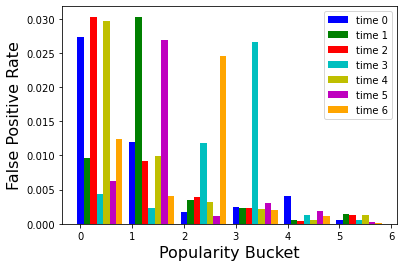

In [63]:
w = 0.125
plt.bar([0,1,2,3,4,5], [comp_time_pop_fp_dict[0][bucket]["rate"] for bucket in comp_time_pop_fp_dict[0]], width=w, color='b', label="time 0", align='center')
plt.bar(np.array([0,1,2,3,4,5])+w, [comp_time_pop_fp_dict[1][bucket]["rate"] for bucket in comp_time_pop_fp_dict[1]], width=w, color='g', label="time 1", align='center')
plt.bar(np.array([0,1,2,3,4,5])+(w*2), [comp_time_pop_fp_dict[2][bucket]["rate"] for bucket in comp_time_pop_fp_dict[2]], width=w, color='r', label="time 2", align='center')
plt.bar(np.array([0,1,2,3,4,5])+(w*3), [comp_time_pop_fp_dict[3][bucket]["rate"] for bucket in comp_time_pop_fp_dict[3]], width=w, color='c', label="time 3", align='center')
plt.bar(np.array([0,1,2,3,4,5])+(w*4), [comp_time_pop_fp_dict[4][bucket]["rate"] for bucket in comp_time_pop_fp_dict[4]], width=w, color='y', label="time 4", align='center')
plt.bar(np.array([0,1,2,3,4,5])+(w*5), [comp_time_pop_fp_dict[5][bucket]["rate"] for bucket in comp_time_pop_fp_dict[5]], width=w, color='m', label="time 5", align='center')
plt.bar(np.array([0,1,2,3,4,5])+(w*6), [comp_time_pop_fp_dict[6][bucket]["rate"] for bucket in comp_time_pop_fp_dict[6]], width=w, color='orange', label="time 6", align='center')
plt.xlabel('Popularity Bucket', fontsize=16)
plt.ylabel('False Positive Rate', fontsize=16)
plt.legend()
plt.show()

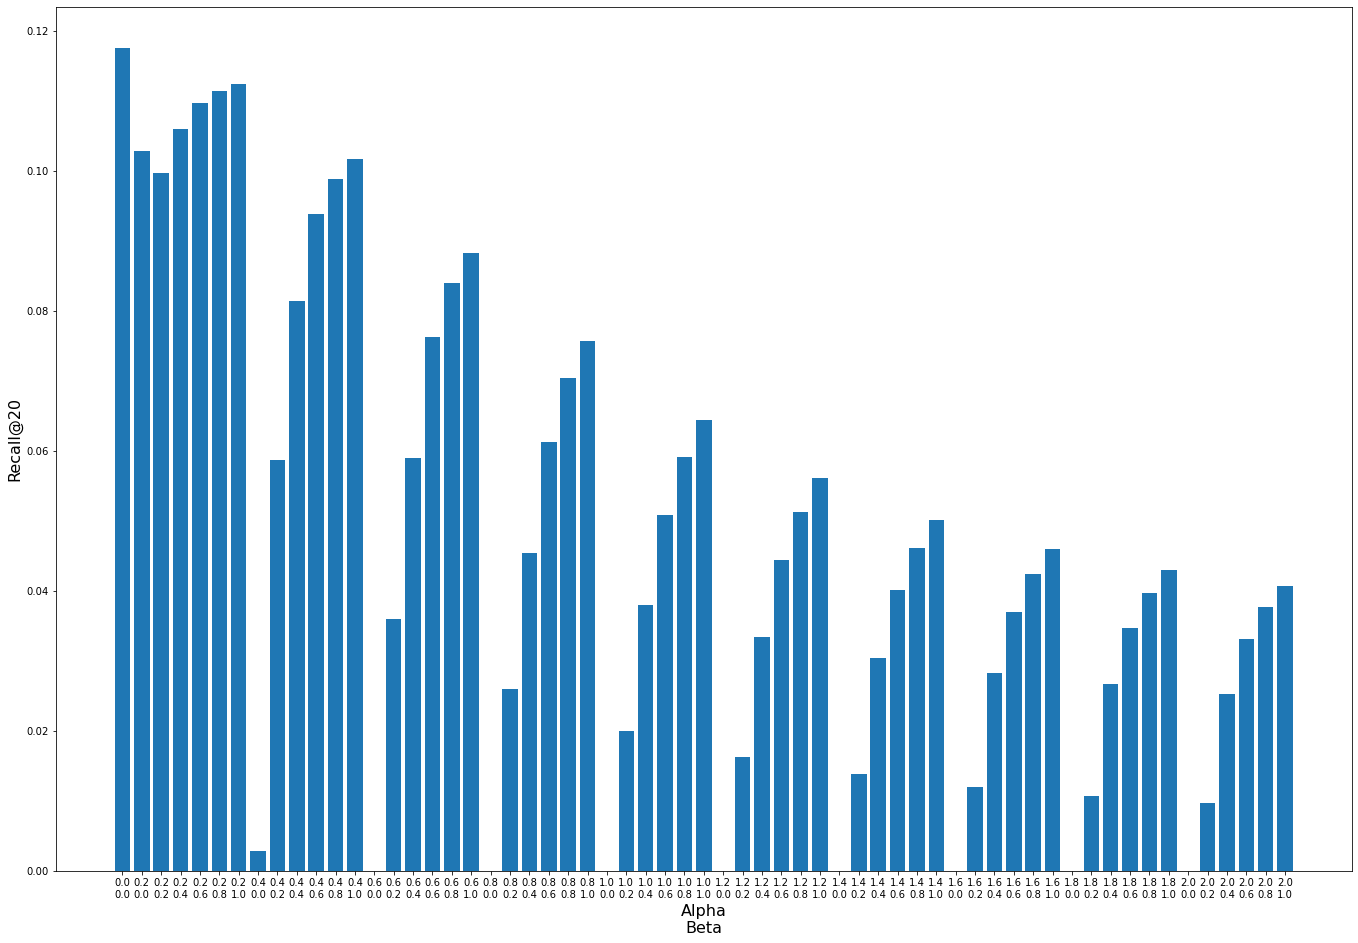

In [129]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,3,3])
# keys = [key for key in a_b_scores_dict.keys()]
# ax.bar([str(round(key[0], 1)) + "\n" + str(round(key[1], 1)) for key in a_b_scores_dict.keys()], [dict["recall"] for dict in a_b_scores_dict.values()])
# plt.xlabel('Alpha' + "\n" + 'Beta', fontsize=16)
# plt.ylabel('Recall@20', fontsize=16)
# plt.show()

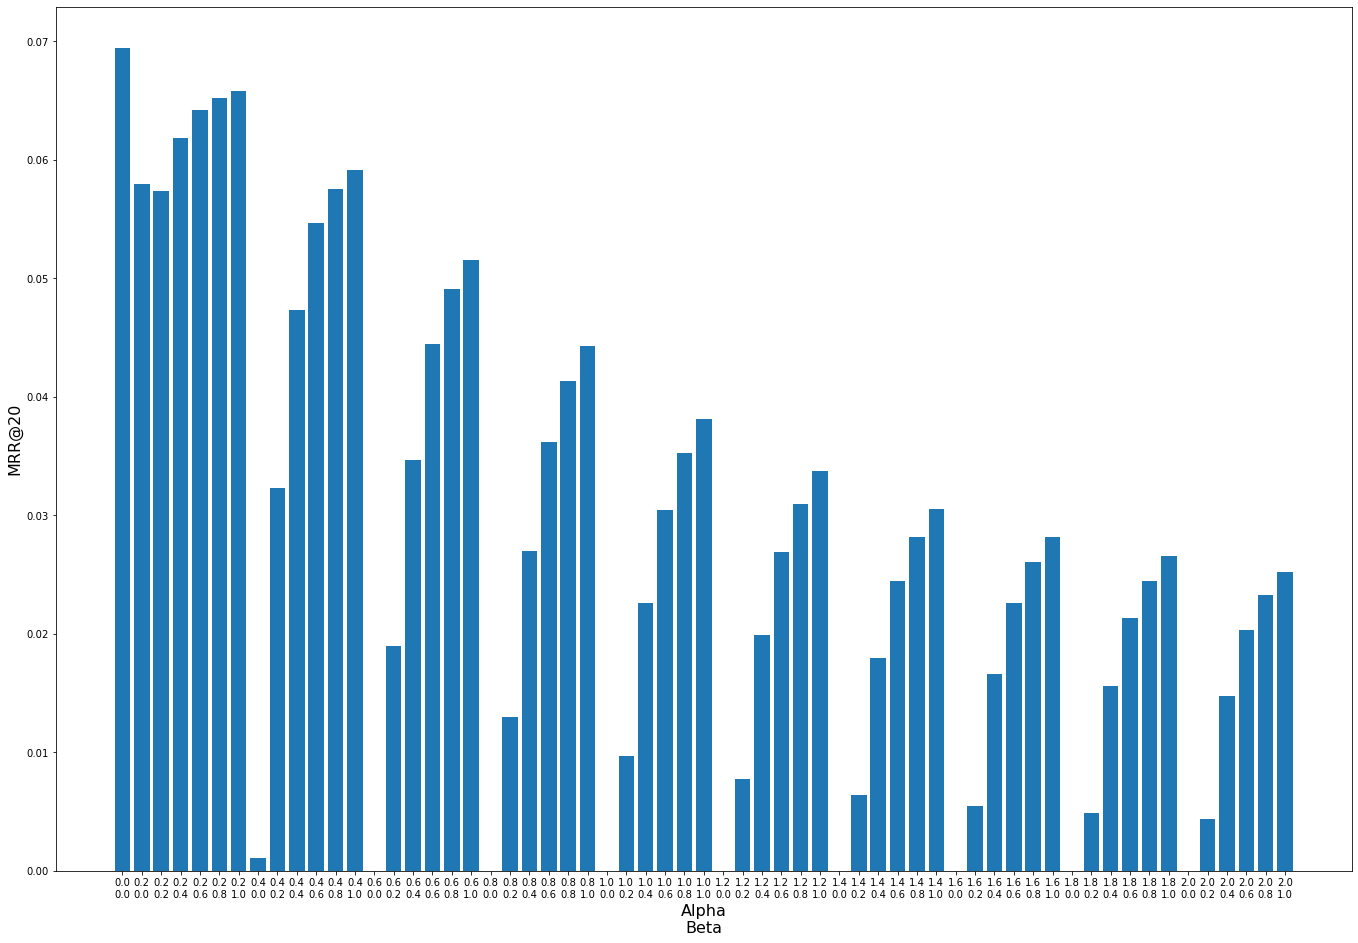

In [131]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,3,3])
# keys = [key for key in a_b_scores_dict.keys()]
# ax.bar([str(round(key[0], 1)) + "\n" + str(round(key[1], 1)) for key in a_b_scores_dict.keys()], [dict["mrr"] for dict in a_b_scores_dict.values()])
# plt.xlabel('Alpha' + "\n" + 'Beta', fontsize=16)
# plt.ylabel('MRR@20', fontsize=16)
# plt.show()

## PRI on subset of test

In [ ]:
# Need all 68008 item ranks for each sequence
model_df = pd.read_csv("test_results.csv.gz", compression="gzip") 

test_item_rank_dict = {}

for batch in np.array_split(model_df, 10000):
    preds = torch.tensor(batch.iloc[:,1:-1].values.tolist())
    
    for seq_preds in preds:
        for rank, pred in enumerate(seq_preds):
            pred = pred.item()
            if pred not in test_item_rank_dict:
                test_item_rank_dict[pred] = []
            test_item_rank_dict[pred].append(rank)

In [52]:
from scipy import stats
# The more correlated popularity and rank of an item are, the higehr the PRI
item_pop_list_pri = []
item_rank_list_pri = []
for item in test_item_rank_dict:
    
    if item in train_item_freq_dict:
        item_avgrank_i = np.mean(test_item_rank_dict[item])
        item_rank_list_pri.append(item_avgrank_i)
    
        item_pop_i = train_item_freq_dict[item]
        item_pop_list_pri.append(item_pop_i)
    
pri = stats.spearmanr(item_pop_list_pri, item_rank_list_pri)[0]
pri = -pri
print("test pri with training popularity =", pri)

test pri with training popularity = 0.7904041683459844


In [54]:
total_item_freq_dict = train_item_freq_dict
test_item_freq_dict = dict(Counter(test_data.m_y_action))
for item in test_item_freq_dict:
    if item not in total_item_freq_dict:
        total_item_freq_dict[item] = 0
    total_item_freq_dict[item] += test_item_freq_dict[item]

item_pop_list_pri = []
item_rank_list_pri = []
for item in test_item_rank_dict:
    if item in total_item_freq_dict:
        item_avgrank_i = np.mean(test_item_rank_dict[item])
        item_rank_list_pri.append(item_avgrank_i)
    
        item_pop_i = total_item_freq_dict[item]
        item_pop_list_pri.append(item_pop_i)
    
pri = stats.spearmanr(item_pop_list_pri, item_rank_list_pri)[0]
pri = -pri
print("test pri with total popularity =", pri)

test pri with total popularity = 0.7683992414875547
